In [2]:
# Start with loading all necessary libraries
import pandas as pd
import pyodbc
import numpy as np
import matplotlib.pyplot as plt
import re

In [3]:
sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                            'SERVER=L_AAGwebapptest;'
                            'DATABASE=BedView;'
                            'Trusted_Connection=yes') 
query = "set transaction isolation level read uncommitted select cn.Diagnosis,ps.SpecialtyDesc,ps.AdmissionDate,ps.DischargeDate,pn.AmuTriage from tblClinicalNote cn inner join tblPatientSpell ps on ps.pkPatientSpellID=cn.fkPatientSpellID inner join tblPatientNote pn on pn.fkPatientSpellID=ps.pkPatientSpellID"
df = pd.read_sql(query, sql_conn)
df = df.dropna()
df

,Diagnosis,SpecialtyDesc,AdmissionDate,DischargeDate,AmuTriage
0,Moderate-Severe Dementia\nDelayed discharge fr...,Geriatric Medicine,2016-05-06 12:00:00,2016-09-21 12:52:00,MOPRS
1,Prolonged medical admission\nCOPD\nCAP\nOld ri...,Respiratory & Thoracic Med,2016-06-06 03:45:00,2016-12-07 14:48:00,-1
2,1. Lewy body dementia,Respiratory & Thoracic Med,2016-06-06 10:50:00,2016-11-04 09:30:00,GIM
3,For Fast track\nRecurrent pneumonias\nHOOF sen...,Geriatric Medicine,2016-06-09 12:00:00,2016-08-12 12:13:00,MOPRS
4,Blocked NG - taken out\nDelirious\nHigh re-fee...,Geriatric Medicine,2016-06-09 15:40:00,2016-08-09 12:00:00,CARDIO
5,1) Korsakoff's\n,Respiratory & Thoracic Med,2016-06-14 16:02:00,2016-11-10 16:30:00,GIM
6,"Ad/m 6/10, PORTS,\nKW = Sadie\n1. PEA arrest 2...",Specialist Rehabilitation,2016-06-17 16:54:00,2016-12-21 16:30:00,GASTRO
7,Medically stable for DC\nHAP: on doxy\nBG: syn...,Geriatric Medicine,2016-06-17 21:58:00,2016-08-15 18:55:00,MOPRS
8,Falls\nDementia\nPost Delirium\nNew R # NOF - ...,Geriatric Medicine,2016-06-19 13:49:00,2016-10-31 17:25:00,MOPRS
9,MFFD,Geriatric Medicine,2016-06-20 18:59:00,2016-08-19 14:45:00,MOPRS


In [44]:
df_AMU = df[df['AmuTriage']!='-1'].copy()
df_AMU

,Diagnosis,SpecialtyDesc,AdmissionDate,DischargeDate,AmuTriage
0,Moderate-Severe Dementia\nDelayed discharge fr...,Geriatric Medicine,2016-05-06 12:00:00,2016-09-21 12:52:00,MOPRS
2,1. Lewy body dementia,Respiratory & Thoracic Med,2016-06-06 10:50:00,2016-11-04 09:30:00,GIM
3,For Fast track\nRecurrent pneumonias\nHOOF sen...,Geriatric Medicine,2016-06-09 12:00:00,2016-08-12 12:13:00,MOPRS
4,Blocked NG - taken out\nDelirious\nHigh re-fee...,Geriatric Medicine,2016-06-09 15:40:00,2016-08-09 12:00:00,CARDIO
5,1) Korsakoff's\n,Respiratory & Thoracic Med,2016-06-14 16:02:00,2016-11-10 16:30:00,GIM
6,"Ad/m 6/10, PORTS,\nKW = Sadie\n1. PEA arrest 2...",Specialist Rehabilitation,2016-06-17 16:54:00,2016-12-21 16:30:00,GASTRO
7,Medically stable for DC\nHAP: on doxy\nBG: syn...,Geriatric Medicine,2016-06-17 21:58:00,2016-08-15 18:55:00,MOPRS
8,Falls\nDementia\nPost Delirium\nNew R # NOF - ...,Geriatric Medicine,2016-06-19 13:49:00,2016-10-31 17:25:00,MOPRS
9,MFFD,Geriatric Medicine,2016-06-20 18:59:00,2016-08-19 14:45:00,MOPRS
10,To sit out daily.\nTry to progress from hoist....,Geriatric Medicine,2016-06-20 20:48:00,2016-08-17 15:10:00,MOPRS


In [45]:
df_AMU = df_AMU[df_AMU['AdmissionDate']>'2018-11-07 09:13:59']
df_AMU

,Diagnosis,SpecialtyDesc,AdmissionDate,DischargeDate,AmuTriage
95464,MFFD\nRe-admission with HAP\n- completed Rx\nB...,General Medicine,2018-12-09 02:49:00,2019-01-05 13:38:00,GIM
101122,pneumonia - left lobe collapse\nasthma,Respiratory & Thoracic Med,2018-11-07 09:20:00,2018-11-12 19:00:00,RESP
101126,(Acute medicine) - Lower respiratory tract inf...,General Medicine,2018-11-07 09:35:00,2018-11-07 15:11:00,ONC
101137,(Acute medicine) - Bronchopneumonia/ Flu. Lung...,General Medicine,2018-11-07 09:53:00,2018-11-07 15:47:00,RESP
101139,(Acute medicine) - Depressive disorder. Needs ...,General Medicine,2018-11-07 13:34:00,2018-11-08 13:45:00,AMU
101143,(Acute medicine) -IE COPD and AF with RVR,Respiratory & Thoracic Med,2018-11-07 11:10:00,2018-11-10 16:00:00,RESP
101147,LRTI\r\nCT proven cholecystitis\r\nNo gallston...,General Surgery,2018-11-07 10:44:00,2018-11-13 18:00:00,SSU
101148,Palliative oesophageal Ca with stent. Fresh ha...,Gastroenterology,2018-11-07 11:37:00,2018-11-09 16:00:00,GASTRO
101151,COPD \nCor Pulmonale \n? Pneumothorax,Respiratory & Thoracic Med,2018-11-07 10:51:00,2018-11-10 09:45:00,RESP
101154,ETOH XS - ALD - Cirrhosis\nCA125 - High\nNo SB...,Hepatology,2018-11-07 09:14:00,2019-02-18 12:35:00,GASTRO


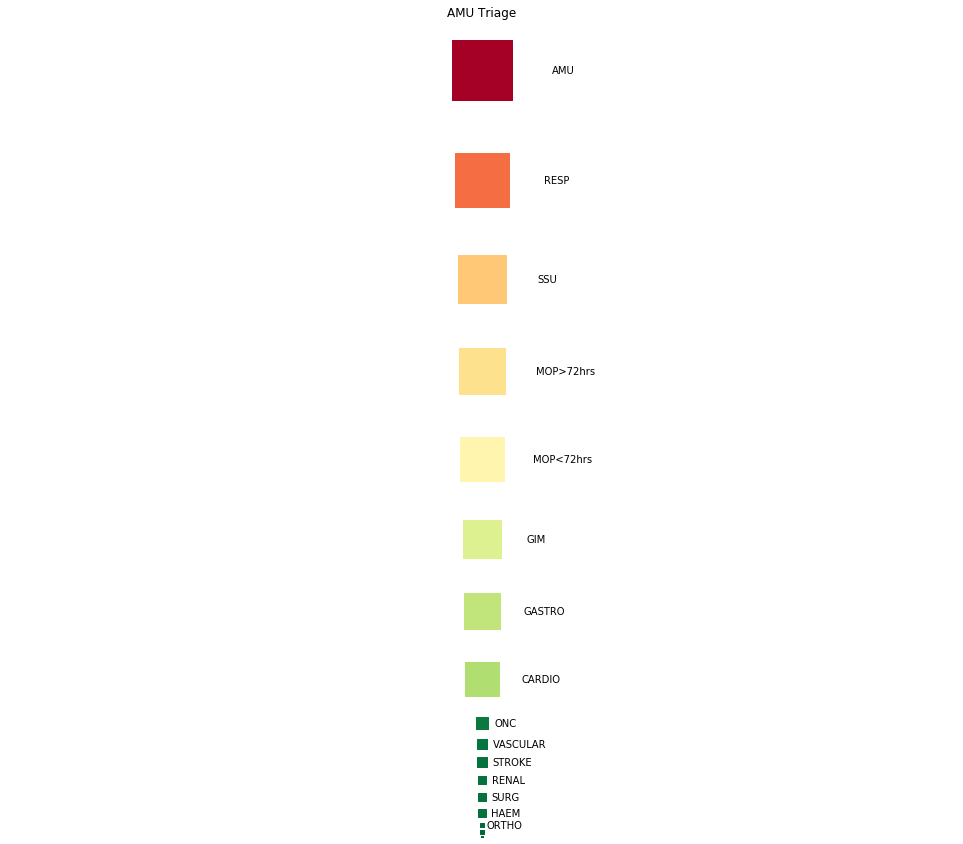

In [46]:
def triage_plot(dataframe):
    triage_counts = dataframe['AmuTriage'].value_counts()
    triage_counts = triage_counts.rename({'-1':'not via AMU'})
    
    sizes = triage_counts*2
    y = []
    cumulative_y = 0
    for size in sizes:
        cumulative_y+=np.sqrt(size)/2
        y.append(cumulative_y)
        cumulative_y+=np.sqrt(size)/2
        
    cm = plt.get_cmap('RdYlGn_r')
    colors = cm(sizes/max(sizes))
    color_dict = {}
    
    plt.figure(figsize=(17,14*y[-1]/400))
    plt.ylim(max(y),np.sqrt(min(y)))
    for i,triage in enumerate(triage_counts.index):
        color_dict[triage] = colors[i]
        plt.scatter(x=0,y=y[i],s=sizes[i],marker='s',color=color_dict[triage])
        if i==0 or y[i]-y[i-1]>4: plt.text((y[-1]/500)*np.sqrt(sizes)[i]/10000,y[i],triage,va='center')
    plt.gca().axis('off');
    plt.title('AMU Triage')
    plt.show()
triage_plot(df_AMU)

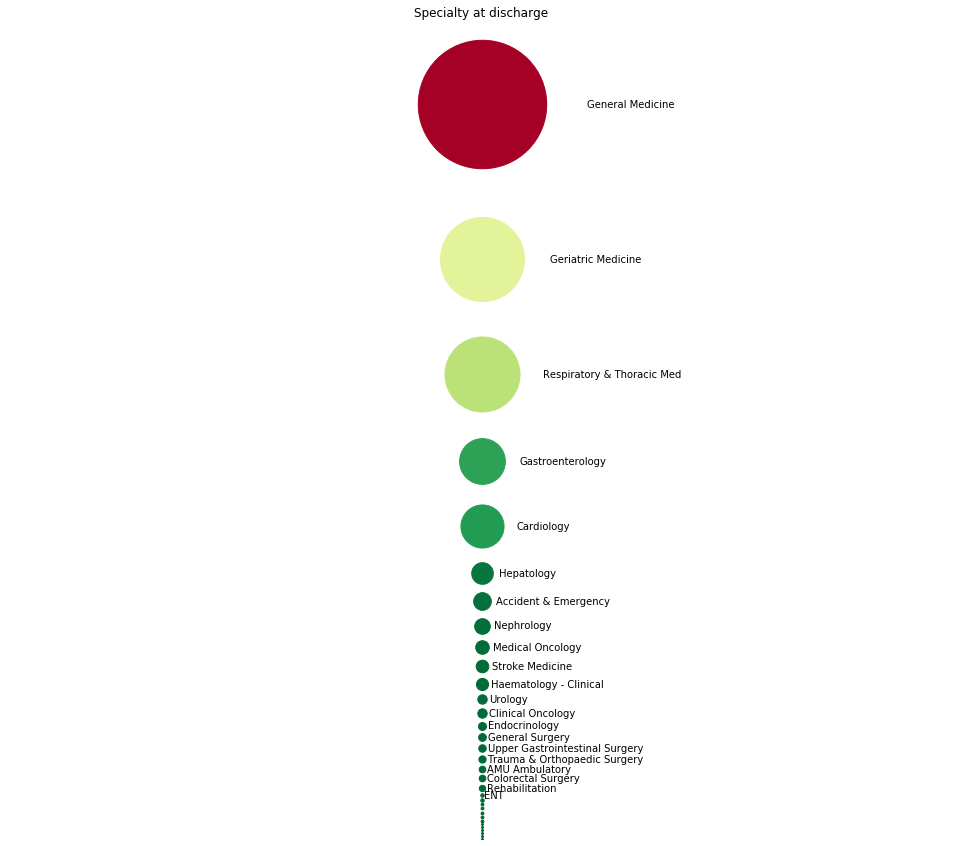

In [47]:
def specialty_plot(dataframe):
    specialty_counts = dataframe['SpecialtyDesc'].value_counts()
    
    sizes = specialty_counts*4
    y = []
    cumulative_y = 0
    for size in sizes:
        cumulative_y+=np.sqrt(size/np.pi)
        y.append(cumulative_y)
        cumulative_y+=np.sqrt(size/np.pi)
        
    cm = plt.get_cmap('RdYlGn_r')
    colors = cm(sizes/max(sizes))
    specialty_color_dict = {}
    
    plt.figure(figsize=(17,14*y[-1]/600))
    plt.ylim(max(y),np.sqrt(min(y)))
    for i,specialty in enumerate(specialty_counts.index):
        specialty_color_dict[specialty] = colors[i]
        plt.scatter(x=0,y=y[i],s=sizes[i],marker='o',color=colors[i])
        if i==0 or y[i]-y[i-1]>4: plt.text((y[-1]/500)*np.sqrt(sizes)[i]/10000,y[i],specialty,va='center')
    plt.gca().axis('off');
    plt.title('Specialty at discharge')
    plt.show()
specialty_plot(df_AMU)

In [56]:
df_AMU['LengthOfStay'] = df_AMU['DischargeDate'] - df_AMU['AdmissionDate']
df_AMU['LengthOfStay'] = df_AMU['LengthOfStay'].astype('timedelta64[D]')
#df_AMU['LengthOfStay'] = df_AMU['LengthOfStay']/np.timedelta64(1,'D')
lenStay = df_AMU['LengthOfStay'].value_counts().sort_index()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<BarContainer object of 7 artists>

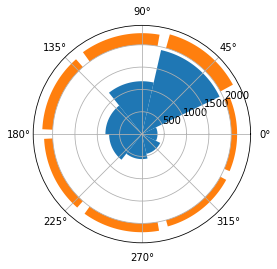

In [81]:
# Compute pie slices
N = 7
width = 2 * np.pi/N
theta = np.linspace(0.0 + width, 2 * np.pi + width, N, endpoint=False)
theta_deg = np.linspace(0.0 + 7.5, 360 + 7.5, N, endpoint=False)
radii = lenStay.values

ax = plt.subplot(111, projection='polar')
ax.bar(theta, radii[0:7], width=width,label='Data');
ax.bar(theta, radii[7:14], bottom=2000)

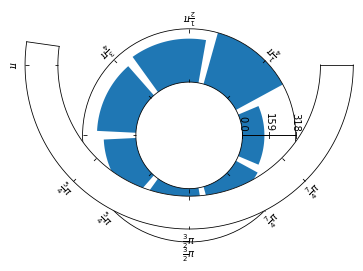

In [112]:
import mpl_toolkits.axisartist.floating_axes as floating_axes
from matplotlib.projections import PolarAxes
from mpl_toolkits.axisartist.grid_finder import FixedLocator, \
     MaxNLocator, DictFormatter
import numpy as np
import matplotlib.pyplot as plt

# "radius" between 0 and a max value of 40,000
# as roughly in your example
# normalize the r coordinates and offset by 1 (will be clear later)
MAX_R = max(lenStay.values[7:14])
radii = lenStay.values[7:14]/MAX_R + 1

# initialize figure:
fig = plt.figure()

# set up polar axis
tr = PolarAxes.PolarTransform()

# define angle ticks around the circumference:
angle_ticks = [(0, r"$0$"),
               (.25*np.pi, r"$\frac{1}{4}\pi$"),
               (.5*np.pi, r"$\frac{1}{2}\pi$"), 
               (.75*np.pi, r"$\frac{3}{4}\pi$"),
               (1.*np.pi, r"$\pi$"),
               (1.25*np.pi, r"$\frac{5}{4}\pi$"),
               (1.5*np.pi, r"$\frac{3}{2}\pi$"),
               (1.75*np.pi, r"$\frac{7}{4}\pi$")]

# set up ticks and spacing around the circle
grid_locator1 = FixedLocator([v for v, s in angle_ticks])
tick_formatter1 = DictFormatter(dict(angle_ticks))

# set up grid spacing along the 'radius'
radius_ticks = [(1., '0.0'),
                (1.5, '%i' % (MAX_R/2.)),
                (2.0, '%i' % (MAX_R))]

grid_locator2 = FixedLocator([v for v, s in radius_ticks])
tick_formatter2 = DictFormatter(dict(radius_ticks))

# set up axis:
# tr: the polar axis setup
# extremes: theta max, theta min, r max, r min
# the grid for the theta axis
# the grid for the r axis
# the tick formatting for the theta axis
# the tick formatting for the r axis
grid_helper = floating_axes.GridHelperCurveLinear(tr,
                                                  extremes=(2.*np.pi, 0, 2, 1),
                                                  grid_locator1=grid_locator1,
                                                  grid_locator2=grid_locator2,
                                                  tick_formatter1=tick_formatter1,
                                                  tick_formatter2=tick_formatter2)

ax1 = floating_axes.FloatingSubplot(fig, 111, grid_helper=grid_helper)
fig.add_subplot(ax1)

# create a parasite axes whose transData in RA, cz
aux_ax = ax1.get_aux_axes(tr)

aux_ax.patch = ax1.patch # for aux_ax to have a clip path as in ax
ax1.patch.zorder=0.9 # but this has a side effect that the patch is
                     # drawn twice, and possibly over some other
                     # artists. So, we decrease the zorder a bit to
                     # prevent this.

# plot your data:
aux_ax.bar(theta, radii)


grid_helper = floating_axes.GridHelperCurveLinear(tr,
                                                  extremes=(2.*np.pi, 3, 5, 4),
                                                  grid_locator1=grid_locator1,
                                                  grid_locator2=grid_locator2,
                                                  tick_formatter1=tick_formatter1,
                                                  tick_formatter2=tick_formatter2)

ax1 = floating_axes.FloatingSubplot(fig, 111, grid_helper=grid_helper)
fig.add_subplot(ax1)

# create a parasite axes whose transData in RA, cz
aux_ax = ax1.get_aux_axes(tr)

aux_ax.patch = ax1.patch # for aux_ax to have a clip path as in ax
ax1.patch.zorder=0.9 # but this has a side effect that the patch is
                     # drawn twice, and possibly over some other
                     # artists. So, we decrease the zorder a bit to
                     # prevent this.

# plot your data:
aux_ax.bar(theta, radii)


plt.show()  

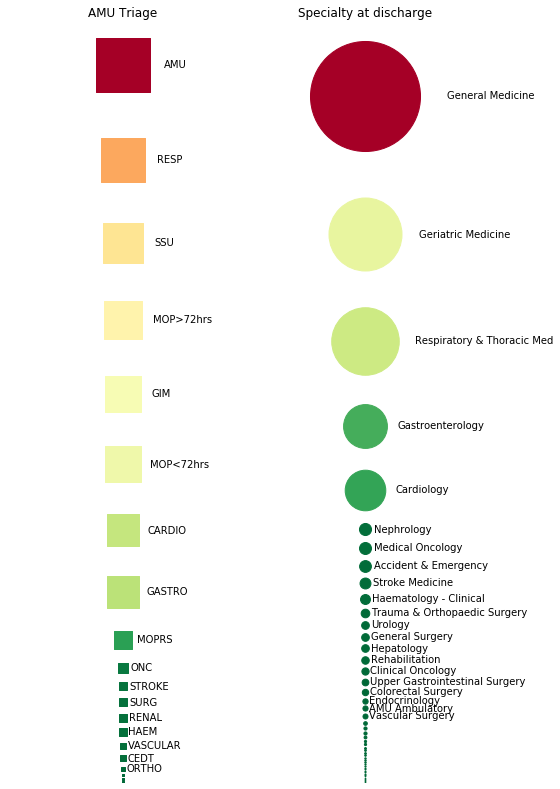

In [23]:
triage_counts = df_AMU['AmuTriage'].value_counts()

triage_sizes = triage_counts/4
triage_y = []
cumulative_triage_y = 0
for size in triage_sizes:
    cumulative_triage_y+=np.sqrt(size)/2
    triage_y.append(cumulative_triage_y)
    cumulative_triage_y+=np.sqrt(size)/2

cm = plt.get_cmap('RdYlGn_r')
triage_colors = cm(triage_sizes/max(triage_sizes))
triage_color_dict = {}


specialty_counts = df_AMU['SpecialtyDesc'].value_counts()

specialty_sizes = specialty_counts/2
specialty_y = []
cumulative_specialty_y = 0
for size in specialty_sizes:
    cumulative_specialty_y+=np.sqrt(size/np.pi)
    specialty_y.append(cumulative_specialty_y)
    cumulative_specialty_y+=np.sqrt(size/np.pi)

specialty_cm_subsection = np.linspace(0, 1, len(specialty_counts))
specialty_colors = cm(specialty_sizes/max(specialty_sizes))
specialty_color_dict = {}

# Display the generated image:
figure, (triage_fig, specialty_fig) = plt.subplots(nrows=1,ncols=2, figsize=(8,14*triage_y[-1]/500))

triage_fig.set_ylim(max(triage_y),np.sqrt(min(triage_y)))
for i,triage in enumerate(triage_counts.index):
    triage_color_dict[triage] = triage_colors[i]
    triage_fig.scatter(x=0,y=triage_y[i],s=triage_sizes[i],marker='s',color=triage_color_dict[triage])
    if i==0 or triage_y[i]-triage_y[i-1]>4: triage_fig.text((specialty_y[-1]/600)*np.sqrt(triage_sizes)[i]/1000,triage_y[i],triage,va='center')
triage_fig.axis('off');
triage_fig.set_title('AMU Triage')

specialty_fig.set_ylim(max(specialty_y),np.sqrt(min(specialty_y)))
for i,specialty in enumerate(specialty_counts.index):
    specialty_color_dict[specialty] = specialty_colors[i]
    specialty_fig.scatter(x=0,y=specialty_y[i],s=specialty_sizes[i],marker='o',color=specialty_color_dict[specialty])
    if i==0 or specialty_y[i]-specialty_y[i-1]>5: specialty_fig.text((specialty_y[-1]/600)*np.sqrt(specialty_sizes)[i]/500,specialty_y[i],specialty,va='center')
specialty_fig.axis('off');
specialty_fig.set_title('Specialty at discharge')
    
plt.tight_layout()
plt.show()

In [6]:
df['Diagnosis'] = df['Diagnosis'].str.lower()

In [7]:
term_to_abbreviation_dict = {'[^a-z]od[^a-z]':' overdose '}

In [8]:
df_19 = df[df['Diagnosis'].str.lower().str.contains(" acute c",case=False)]
print(df_19['Diagnosis'].values)

['1. acute confusion ' 'ms. acute confusion\nuti'
 'aki, low k resolved. acute confusion recent hyoscine'
 '1. acute confusion on chronic cognitive impairment'
 '1. acute confusion w/ hallucinations\n2. ccf\n3. mca admission, dnacpr'
 '1. acute confusion\n2. ? cerebellar signs\n3 hyponatraemia (113)\n4 ? illicit drugs at recent festival'
 "multiple issues\n1. failed discharge\n2. worsening heart failure\n3. acute confusion + worsening inflammatory markers. ? urine/ ? skin \n4. recurrent falls \n5. cholestatic lft's "
 '1. acute confusion on dementia\n2. self twoc\n3. retention - new catheter\n4. lost hearing aids'
 '1. acute confusion of known delirium patient.\n2. aki + urinary retention '
 'general decline, acute confusion. \nlow bms, worsening ankle oedema, \nuti?  urine dip-nitite+leuk+blood+, recent incontinence\nthrombocytopenia- platelet 45. recent episodes of epistaxis\ncxr- left costophrenic angle consolidation/effusion?\nhypercalcaemia, mild aki'
 '1. acute confusion on bg of

In [9]:
df_AMU['Diagnosis'] = df['Diagnosis'].replace(term_to_abbreviation_dict, regex=True)
df_19 = df[df['Diagnosis'].str.lower().str.contains("[^a-z]od[^a-z]",case=False)]
print(len(df_19['Diagnosis'].values))

0


In [10]:
re.sub(r"(\s)sat(\s[0-9][0-9]%)", r"\1saturated\2", 'Currently sat 94%')

'Currently saturated 94%'

In [11]:
snomedct = pd.read_csv('sct2_Description_Snapshot-en_INT_20190731.txt',sep="\t",usecols=['term'])
consecutive_caps_after = snomedct['term'].str.findall(r"((?:\b[A-Za-z]+\b\s)+\([A-Z][A-Z]+\))")
consecutive_caps_after = consecutive_caps_after[consecutive_caps_after.astype(str)!='[]']
consecutive_caps_after = consecutive_caps_after.dropna()
slist = []
for x in consecutive_caps_after:
    slist.extend(x)

term_to_abbreviation_dict = {}
for l in slist:
    inside_brackets = re.findall(r"\(([A-Za-z]+)\)", l)[0]
    len_inside_brackets = len(inside_brackets)
    num_words = len(l.split()) - 1
    if len_inside_brackets == num_words:
        words_before_brackets = []
        for i in range(len_inside_brackets):
            if i<num_words: words_before_brackets.insert(0,l.split(" ")[-i-2])
        string_before_brackets = " ".join(words_before_brackets)
        if all(words_before_brackets[i].lower()[0]==inside_brackets[i].lower() for i in range(len_inside_brackets)):
            if string_before_brackets not in term_to_abbreviation_dict.keys() and inside_brackets not in term_to_abbreviation_dict.values():
                term_to_abbreviation_dict[string_before_brackets] = inside_brackets
        

consecutive_caps_before = snomedct['term'].str.findall(r"[A-Za-z][A-Za-z]+\s\((?:\b[A-Za-z]+\b\s)(?:\b[A-Za-z]+\b\s?)+\)")
consecutive_caps_before = consecutive_caps_before[consecutive_caps_before.astype(str)!='[]']
consecutive_caps_before = consecutive_caps_before.dropna()
slist = []
for x in consecutive_caps_before:
    slist.extend(x)
for l in slist:
    inside_brackets = re.findall(r"\((?:\b[A-Za-z]+\b\s)(?:\b[A-Za-z]+\b\s?)+\)", l)[0]
    inside_brackets = inside_brackets.strip('()')
    words_inside_brackets = inside_brackets.split()
    num_words_inside_brackets = len(words_inside_brackets)
    word_before_brackets = l.split()[0]
    if num_words_inside_brackets==len(word_before_brackets) and all(words_inside_brackets[i].lower()[0]==word_before_brackets[i].lower() for i in range(num_words_inside_brackets)):
        if inside_brackets not in term_to_abbreviation_dict.keys() and word_before_brackets not in term_to_abbreviation_dict.values():
            term_to_abbreviation_dict[inside_brackets] = word_before_brackets
            

consecutive_caps_dash = snomedct['term'].str.findall(r"[A-Za-z][A-Za-z]+\s\-\s(?:\b[A-Za-z]+\b\s)(?:\b[A-Za-z]+\b\s?)+")
consecutive_caps_dash = consecutive_caps_dash[consecutive_caps_dash.astype(str)!='[]']
consecutive_caps_dash = consecutive_caps_dash.dropna()
slist = []
for x in consecutive_caps_dash:
    slist.extend(x)
for l in slist:
    after_dash = l.split(' - ')[1]
    words_after_dash = after_dash.split()
    num_words_after_dash = len(words_after_dash)
    word_before_dash = l.split(' - ')[0]
    if num_words_after_dash==len(word_before_dash) and all(words_after_dash[i].lower()[0]==word_before_dash[i].lower() for i in range(num_words_after_dash)):
        if after_dash not in term_to_abbreviation_dict.keys():
            term_to_abbreviation_dict[after_dash] = word_before_dash



consecutive_caps_after = df['Diagnosis'].str.findall(r"((?:\b[A-Za-z]+\b\s)+\([A-Z][A-Z]+\))")
consecutive_caps_after = consecutive_caps_after[consecutive_caps_after.astype(str)!='[]']
consecutive_caps_after = consecutive_caps_after.dropna()
slist = []
for x in consecutive_caps_after:
    slist.extend(x)

for l in slist:
    inside_brackets = re.findall(r"\(([A-Za-z]+)\)", l)[0]
    len_inside_brackets = len(inside_brackets)
    num_words = len(l.split()) - 1
    if len_inside_brackets == num_words:
        words_before_brackets = []
        for i in range(len_inside_brackets):
            if i<num_words: words_before_brackets.insert(0,l.split()[-i-2])
        string_before_brackets = " ".join(words_before_brackets)
        if all(words_before_brackets[i].lower()[0]==inside_brackets[i].lower() for i in range(len_inside_brackets)):
            if string_before_brackets not in term_to_abbreviation_dict.keys() and inside_brackets not in term_to_abbreviation_dict.values():
                term_to_abbreviation_dict[string_before_brackets] = inside_brackets
        

consecutive_caps_before = df['Diagnosis'].str.findall(r"[A-Za-z][A-Za-z]+\s\((?:\b[A-Za-z]+\b\s)(?:\b[A-Za-z]+\b\s?)+\)")
consecutive_caps_before = consecutive_caps_before[consecutive_caps_before.astype(str)!='[]']
consecutive_caps_before = consecutive_caps_before.dropna()
slist = []
for x in consecutive_caps_before:
    slist.extend(x)
for l in slist:
    inside_brackets = re.findall(r"\((?:\b[A-Za-z]+\b\s)(?:\b[A-Za-z]+\b\s?)+\)", l)[0]
    inside_brackets = inside_brackets.strip('()')
    words_inside_brackets = inside_brackets.split()
    num_words_inside_brackets = len(words_inside_brackets)
    word_before_brackets = l.split()[0]
    if num_words_inside_brackets==len(word_before_brackets) and all(words_inside_brackets[i].lower()[0]==word_before_brackets[i].lower() for i in range(num_words_inside_brackets)):
        if inside_brackets not in term_to_abbreviation_dict.keys() and word_before_brackets not in term_to_abbreviation_dict.values():
            term_to_abbreviation_dict[inside_brackets] = word_before_brackets
            

consecutive_caps_dash = df['Diagnosis'].str.findall(r"[A-Za-z][A-Za-z]+\s\-\s(?:\b[A-Za-z]+\b\s)(?:\b[A-Za-z]+\b\s?)+")
consecutive_caps_dash = consecutive_caps_dash[consecutive_caps_dash.astype(str)!='[]']
consecutive_caps_dash = consecutive_caps_dash.dropna()
slist = []
for x in consecutive_caps_dash:
    slist.extend(x)
for l in slist:
    after_dash = l.split('-')[1]
    words_after_dash = after_dash.split()
    num_words_after_dash = len(words_after_dash)
    word_before_dash = l.split(' - ')[0]
    if num_words_after_dash==len(word_before_dash) and all(words_after_dash[i].lower()[0]==word_before_dash[i].lower() for i in range(num_words_after_dash)):
        after_dash = after_dash.strip()
        if after_dash not in term_to_abbreviation_dict.keys() and word_before_dash not in term_to_abbreviation_dict.values():
            term_to_abbreviation_dict[after_dash] = word_before_dash
        
term_to_abbreviation_dict['trop'] = 'troponin'
term_to_abbreviation_dict['inf ex'] = 'infective ex'
term_to_abbreviation_dict['inf asthma'] = 'infective asthma'
term_to_abbreviation_dict[' exa '] = ' exacerbation '
term_to_abbreviation_dict['exac[^a-z]'] = 'exacerbation '
term_to_abbreviation_dict['ex copd'] = 'exacerbation copd'
term_to_abbreviation_dict['copd ex '] = 'copd exacerbation '
term_to_abbreviation_dict['ex of'] = 'exacerbation of'
term_to_abbreviation_dict['ex asthma'] = 'exacerbation asthma'
term_to_abbreviation_dict['ex due'] = 'exacerbation due'
term_to_abbreviation_dict['ex chronic'] = 'exacerbation chronic'
term_to_abbreviation_dict['infective exacerbation'] = 'ie'
term_to_abbreviation_dict['infected exacerbation'] = 'ie'
term_to_abbreviation_dict['ie of copd'] = 'iecopd'
term_to_abbreviation_dict['ie copd'] = 'iecopd'
term_to_abbreviation_dict['ie- copd'] = 'iecopd'
term_to_abbreviation_dict['ie-copd'] = 'iecopd'
term_to_abbreviation_dict['pulmonary embolism'] = 'pe'
term_to_abbreviation_dict['nebuliser'] = 'neb'
term_to_abbreviation_dict['nebulizer'] = 'neb'
term_to_abbreviation_dict['nebulisers'] = 'nebs'
term_to_abbreviation_dict['nebulizers'] = 'nebs'
term_to_abbreviation_dict['influenza'] = 'flu'
term_to_abbreviation_dict['over dose'] = 'overdose'
term_to_abbreviation_dict['[^a-z]od[^a-z]'] = ' overdose '
term_to_abbreviation_dict['msk'] = 'musculoskeletal'
term_to_abbreviation_dict['o2 sat'] = 'oxygen saturation'
term_to_abbreviation_dict['o sat'] = 'oxygen saturation'
term_to_abbreviation_dict['sat of'] = 'saturation of'
term_to_abbreviation_dict['sat %'] = 'saturation %'
term_to_abbreviation_dict['sat ?'] = 'saturday %'
term_to_abbreviation_dict['sat 0'] = 'saturday 0'
term_to_abbreviation_dict['lupus ac'] = 'lupus anticoagulant'
term_to_abbreviation_dict['ac confusion'] = 'acute confusion'
term_to_abbreviation_dict[' ac joint'] = ' acromioclavicular joint'
term_to_abbreviation_dict[' ac left'] = ' acute left'
term_to_abbreviation_dict['ac ross'] = 'across'
term_to_abbreviation_dict['ac appendicitis'] = 'acute appendicitis'

#term_to_abbreviation_dict = {key.lower():val.lower() for (key,val) in term_to_abbreviation_dict.items()}
for key,val in term_to_abbreviation_dict.items():
    print(key+" & "+val+'\\\\')

dead on arrival & DOA\\
minimum bactericidal concentration & MBC\\
increased anion gap & IAG\\
minimum inhibitory concentration & MIC\\
Atrial natriuretic factor & ANF\\
Anaplastic large cell lymphoma & ALCL\\
Estrogen receptor assay & ERA\\
Thyrotropin releasing hormone & TRH\\
normal anion gap & NAG\\
Prothrombin time & PT\\
Foreign body & FB\\
Peripherally inserted central & PIC\\
Transcutaneous Electrical Nerve Stimulation & TENS\\
Vulval intraepithelial neoplasia & VIN\\
International normalised ratio & INR\\
Forced vital capacity & FVC\\
sexually transmitted disease & STD\\
Direct fluorescent antibody & DFA\\
Recreational vehicle & RV\\
Human immunodeficiency virus & HIV\\
World Health Organization & WHO\\
Ductal carcinoma in situ & DCIS\\
Natural killer & NK\\
High density lipoprotein & HDL\\
Intermediate density lipoprotein & IDL\\
Very low density lipoprotein & VLDL\\
White blood cells & WBC\\
Low density lipoprotein & LDL\\
Human leukocyte antigen & HLA\\
Tumor growth factor 

Pemphigus vulgaris & PV\\
Atrial fibrillation & AF\\
Gonadotrophin releasing hormone & GRH\\
Tricuspid stenosis & TS\\
Juvenile periodontitis & JP\\
Central pain & CP\\
Retrograde ejaculation & RE\\
Home visit & HV\\
Lower respiratory tract infection & LRTI\\
Granulomatous colitis & GC\\
Branch retinal artery occlusion & BRAO\\
Basilar membrane & BM\\
Nerve conduction study & NCS\\
Sudden infant death syndrome & SIDS\\
Keratosis pilaris & KP\\
Adenocarcinoma in situ & AIS\\
Retrograde amnesia & RA\\
New vessels iris & NVI\\
Nephrotic syndrome & NS\\
Amino acid & AA\\
Rest pain & RP\\
Spinal muscular atrophy & SMA\\
Chronic actinic dermatitis & CAD\\
Nursing auxiliary & NA\\
Mitral valve replacement & MVR\\
Venous blood & VB\\
Candida albicans & CA\\
Pulmonary vein & PV\\
Congenital lactase deficiency & CLD\\
Human placental lactogen & hPL\\
Direct bilirubin & DB\\
Conjugated bilirubin & CB\\
Bile acid & BA\\
Failure to thrive & FTT\\
Cardiac index & CI\\
Enterobius vermicularis & Ev\\


In [90]:
df_AMU['SpecialtyDesc'].value_counts()

General Medicine                  4125
Geriatric Medicine                1765
Respiratory & Thoracic Med        1407
Gastroenterology                   524
Cardiology                         464
Hepatology                         117
Accident & Emergency                78
Nephrology                          61
Medical Oncology                    46
Stroke Medicine                     40
Haematology - Clinical              37
Clinical Oncology                   22
Urology                             22
Endocrinology                       16
General Surgery                     15
Upper Gastrointestinal Surgery      14
Trauma & Orthopaedic Surgery        13
AMU Ambulatory                      11
Colorectal Surgery                  11
Rehabilitation                      10
ENT                                  3
Gynaecology                          3
Intermediate Care Step Up            2
Plastic Surgery                      2
Oral Surgery                         2
Breast Surgery           

In [13]:
df_19 = df_AMU[df_AMU['Diagnosis'].str.lower().str.contains("acute coronary syndrome",case=False)]
print(df_19['Diagnosis'].values)

['(bed - mau orange) - acute coronary syndrome (acs)'
 'nkda\npc: sob, generally unwell, mild chest tightness.\nimp - acute coronary syndrome (acs), silent mi, ?ccf'
 '(medicine) - acute coronary syndrome (acs)'
 '(medicine) - acute coronary syndrome (acs)'
 '(medicine) - acute coronary syndrome (acs)'
 '(medicine) - acute coronary syndrome (acs)'
 'acute coronary syndrome (acs)\nrepeat troponin 0.05\nbg: type i dm, ckd stage 4 (awaiting spk), ihd - nstemi feb 17.'
 '(medicine) - acute coronary syndrome (acs)\nsudden onset central chest pain'
 '(medicine) - acute coronary syndrome (acs)'
 '(medicine) - acute coronary syndrome (acs)' 'acute coronary syndrome'
 '(medicine) - acute coronary syndrome (acs)\nprobable iron deficiency'
 '(aec) - exclude acute coronary syndrome (acs)\n?pe\n?anxiety'
 '(medicine) - acute coronary syndrome (acs)'
 ' acute coronary syndrome (acs)\nnstemi'
 '(acute medicine) - acute coronary syndrome (acs)\nprevious cabg'
 'allergy - penicillin & codeine. (medicin

In [14]:
df_AMU['Diagnosis'] = df_AMU['Diagnosis'].str.lower()   

In [15]:
df_AMU['Diagnosis'] = df_AMU['Diagnosis'].replace(term_to_abbreviation_dict, regex=True)

In [16]:
df_AMU = df_AMU.replace({'Diagnosis': term_to_abbreviation_dict})

In [17]:
df_AMU['Diagnosis'].replace(term_to_abbreviation_dict, inplace=True)

In [18]:
df_AMU[df_AMU['Diagnosis'].str.contains('acute corononary syndrome')]

,Diagnosis,SpecialtyDesc,AdmissionDate,DischargeDate,AmuTriage


In [19]:
df_nonAMU = df[df['AmuTriage']=='-1'].copy()
df_nonAMU

,Diagnosis,SpecialtyDesc,AdmissionDate,DischargeDate,AmuTriage
1,prolonged medical admission\ncopd\ncap\nold ri...,Respiratory & Thoracic Med,2016-06-06 03:45:00,2016-12-07 14:48:00,-1
22,delirium - on going despite normalisation of b...,Geriatric Medicine,2016-07-07 13:29:00,2016-08-15 16:00:00,-1
31,adm: 15/7\npc: headache + confusion\nimp: resi...,Stroke Medicine,2016-07-15 22:45:00,2016-10-25 10:13:00,-1
32,amber\ncompleted abx for hap\nsbo,Geriatric Medicine,2016-07-17 08:01:00,2016-09-16 15:30:00,-1
44,,Rehabilitation,2016-07-24 03:10:00,2016-10-06 15:05:00,-1
52,"us - adm: 27/07\npc: found on floor >24hrs, rs...",Rehabilitation,2016-07-27 18:44:00,2016-12-03 13:00:00,-1
130,decomp etoh liver disease\nsbp,General Medicine,2016-08-02 21:14:00,2016-08-03 06:06:00,-1
164,icopd,Respiratory & Thoracic Med,2016-08-03 04:31:00,2016-08-11 15:55:00,-1
212,1. chest pain (acs vs. severe as)\n2. metastat...,General Medicine,2016-08-04 02:53:00,2016-08-04 10:21:00,-1
215,1. ie of copd/ lt basal cap,Respiratory & Thoracic Med,2016-08-04 04:32:00,2016-08-12 11:05:00,-1


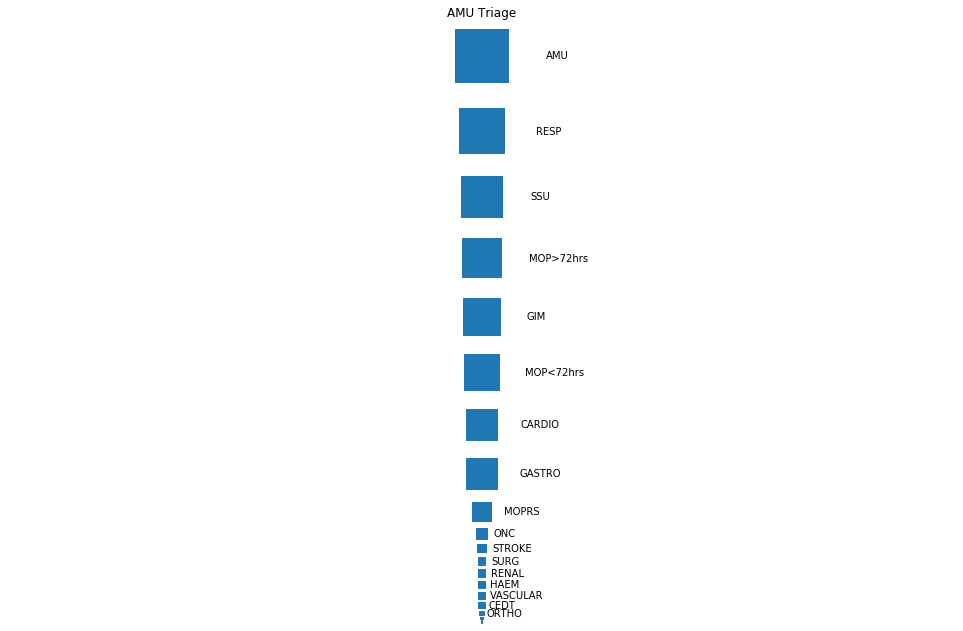

In [20]:
def triage_plot(dataframe):
    triage_counts = dataframe['AmuTriage'].value_counts()
    triage_counts = triage_counts.rename({'-1':'not via AMU'})
    sizes = triage_counts/4
    y = []
    cumulative_y = 0
    for size in sizes:
        cumulative_y+=np.sqrt(size)/2
        y.append(cumulative_y)
        cumulative_y+=np.sqrt(size)/2
    plt.figure(figsize=(17,14*y[-1]/500))
    plt.scatter(x=np.zeros(len(triage_counts)),y=y,s=sizes,marker='s')
    plt.ylim(max(y),np.sqrt(min(y)))
    for i,triage in enumerate(triage_counts.index):
        if i==0 or y[i]-y[i-1]>4: plt.text((y[-1]/500)*np.sqrt(sizes)[i]/10000,y[i],triage,va='center')
    plt.gca().axis('off');
    plt.title('AMU Triage')
    plt.show()
triage_plot(df_AMU)